In [16]:
from sysid.subspace_cupy_fp16 import subspace_det_algo1, prbs, nrms, symmetric_mean_absolute_percentage_error, \
    index_of_agreement, mean_absolute_percentage_error, mean_absolute_scaled_error
from sysid.ss_cupy_fp16 import StateSpaceDiscreteLinear, StateSpaceDataList, StateSpaceDataArray
import time
import pandas as pd
import cupy as np
import numpy
import matplotlib.pyplot as plt

In [17]:
#Virtual DATA
tf = 100  # 365 * 5
dt = 1
plot_stuff = True

u_dimensions = 2
y_dimensions = 2

data_u = np.random.randn(u_dimensions, tf)  # 40 * 45
# data_y = np.random.randn(3, tf)  # 40 * 45
white_noise = 0.1 *  np.random.randn(y_dimensions, tf)
uniform_noise = 0.1 *  np.random.rand(y_dimensions, tf)
data_y2 = 80 + 30 * (data_u[0:y_dimensions,:] + white_noise + uniform_noise) # 40 * 45

# Regularize data
data_y = (data_y2 - np.mean(data_y2)) / np.std(data_y2)

data_y.shape

(2, 100)

In [18]:
# S & P 100 DATA

days = tf = 365 * 2  # 365 * 5
top_correlated = 15
days_fill_range = 365 * 2

dt = 1
plot_stuff = True
df1 = pd.read_csv('sp500_joined_closes.csv')
df1 = df1.set_index("Date")
df1= df1.astype(float)

df1 = df1.interpolate(limit=days_fill_range)
df1 = df1.ffill(limit=days_fill_range).bfill(limit=days_fill_range)

df = df1.tail(tf)
min_max_df=(df-df.min())/(df.max()-df.min())
normalized_df=(df-df.mean())/(df.std())

# normalized_df = normalized_df.interpolate(limit=days_fill_range)
# normalized_df = normalized_df.bfill(limit=days_fill_range).ffill(limit=days_fill_range)

y_labels = ["MSFT", "AMD", "AAPL", "INTC"]

corr0 = normalized_df.corr(method="spearman").abs()
corr1 = corr0[corr0 <0.99999]
corr2 = corr1[corr1>0.5]
corr3 = corr2.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()

u_labels = []
for y_label in y_labels:
    u_labels = u_labels + corr3[y_label].head(top_correlated).index.tolist()
    
u_labels = list(dict.fromkeys(u_labels))
# 
for y_label in y_labels:
    if y_label in u_labels:
        u_labels.remove(y_label)

print("NaNs?", normalized_df[u_labels + y_labels].isnull().values.any())

data_u = normalized_df[u_labels].tail(tf).values.T
data_y = normalized_df[y_labels].tail(tf).values.T

u_dimensions = len(u_labels)
y_dimensions = len(y_labels)

NaNs? False


In [19]:
# Most correlated 
corr0 = df.corr(method="spearman").abs()
corr1 = corr0[corr0 <0.99999]
corr2 = corr1[corr1>0.5]
corr3 = corr2.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()
corr3["MSFT"].head(5)
# corr3["TSLA"].head(10)
# corr3["AAPL"].head(10)

COST    0.986482
TMO     0.981764
MSCI    0.976596
NEE     0.973093
DHR     0.970642
dtype: float64

In [20]:
print("data_u.shape: {}, data_y.shape: {}".format(data_u.shape, data_y.shape))
print("MIMO [{} IN, {} OUT], {} time-steps.".format(data_u.shape[0], data_y.shape[0], data_u.shape[1]))

def f_prbs_4d(t, x, i):
    return np.array([data_u[:, i]], dtype=numpy.float16).T

start_time = time.time()  # Serial
ss3_id = subspace_det_algo1(y=data_y, u=data_u,
    f=5,  # 5 Forward steps
    p=5,  # 5 Backward steps
    s_tol=0.01,  # 0.2
    dt=dt,
    order=-1)
print("--- GPU Execution time:\t\t{} seconds".format(time.time() - start_time))

data_u.shape: (39, 730), data_y.shape: (4, 730)
MIMO [39 IN, 4 OUT], 730 time-steps.
--- GPU Execution time:		0.9389934539794922 seconds


In [21]:
data3_id = ss3_id.simulate(
    f_u=f_prbs_4d,
    x0=np.array([np.zeros(ss3_id.A.shape[0])], dtype=numpy.float16).T,
    tf=tf)


Total NRMSE: 0.711
Total sMAPE: 92.61%
Total MAPE: 10.81%
Total IOA: 79.56%


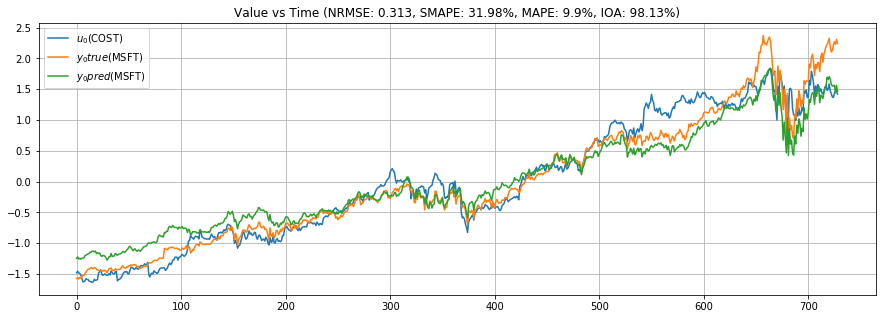

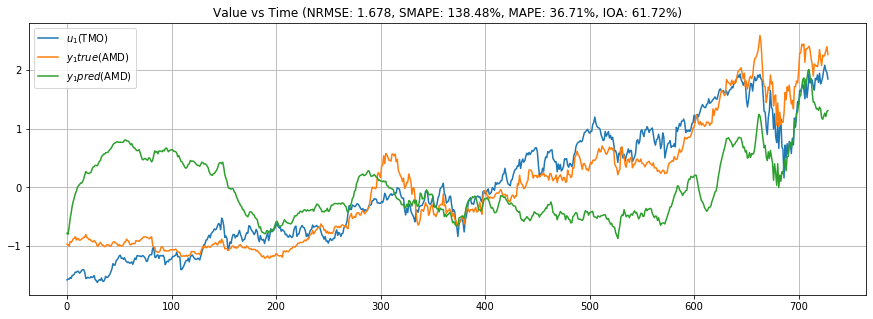

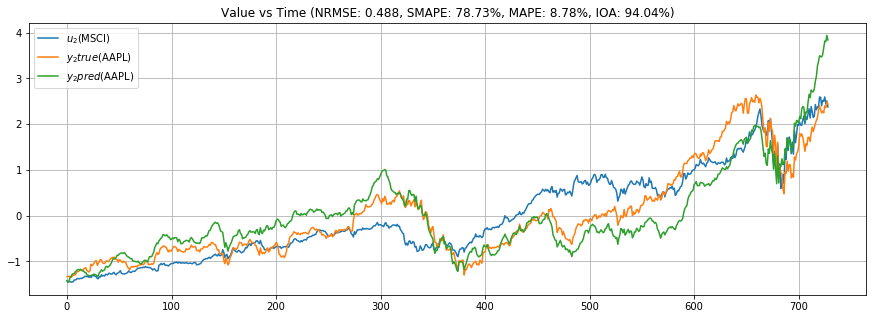

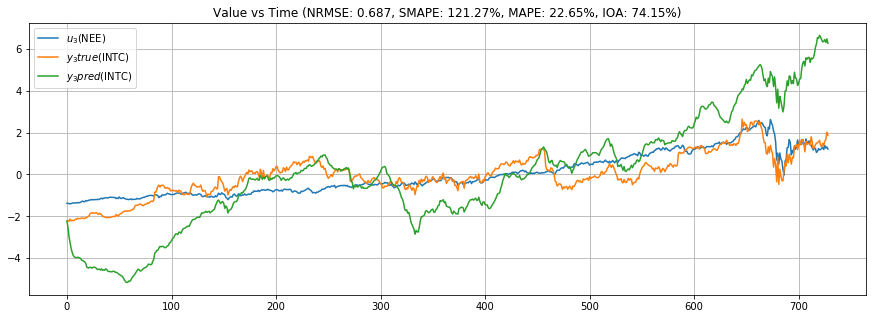

In [22]:
timesteps = data3_id.t.tolist()
for i in range(y_dimensions):    
    plt.figure(figsize=(15,5))
    plt.plot(timesteps, data3_id.u[:,i,:][0].tolist(), label='$u_{:d}$({})'.format(i, u_labels[i]))   
    plt.plot(timesteps, data_y[i,:-1].tolist(), label='$y_{:d}true$({})'.format(i, y_labels[i]))         
    plt.plot(timesteps, data3_id.y[:,i,:][0].tolist(), label='$y_{:d} pred$({})'.format(i, y_labels[i]))
    plt.legend()
    plt.grid()
    max_val = float(max(data_y[i, :-1].max(), data3_id.y[:,i,:][0].max()))
    
    plt.title("Value vs Time (NRMSE: {}, SMAPE: {}%, MAPE: {}%, IOA: {}%)".format(
        round(float(nrms(np.array(data_y[i, :-1]), np.array(data3_id.y[:,i,:][0]))), 3), 
        round(float(symmetric_mean_absolute_percentage_error(np.array(data_y[i, :-1]),np.array(data3_id.y[:,i,:][0]))), 2),
        round(float(mean_absolute_percentage_error(np.array(max_val + data_y[i, :-1]),np.array(max_val + data3_id.y[:,i,:][0]))), 2),
        100 * round(float(index_of_agreement(np.array(data_y[i, :-1]),np.array(data3_id.y[:,i,:][0]))), 4)
    ))

max_val = float(max(data_y[:, :-1].max(), data3_id.y[:,:,:][0].max()))
print("Total NRMSE: {}".format(round(float(nrms(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 3)))
print("Total sMAPE: {}%".format(round(float(symmetric_mean_absolute_percentage_error(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 2)))
print("Total MAPE: {}%".format(round(float(mean_absolute_percentage_error(np.array(max_val + data_y[:, :-1]),np.array(max_val + data3_id.y[0]))), 2)))
print("Total IOA: {}%".format(100 * round(float(index_of_agreement(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 4)))